In [1]:
import sys
from pathlib import Path
sys.path.insert(0, "..")

In [2]:
import torch
from typing import List
import matplotlib.pyplot as plt
from einops import rearrange 

from models.model_configs import instantiate_model
from cfg_scale import CFGScaledModel
from ode_solver import ODESolver
from utils.utils import get_device

In [3]:
def display(image):
    x = image.squeeze(0)
    x = rearrange(x, 'c h w -> h w c')
    x = x.numpy()
    plt.imshow(x)
    plt.show()


device = get_device()


def inference(checkpoint_path: str):
    checkpoint = torch.load(checkpoint_path)
    model=instantiate_model("flow_matching")
    model.load_state_dict(checkpoint)

    cfg_model = CFGScaledModel(model=model)
    cfg_model.cuda()

    cfg_model.eval()
    solver = ODESolver(velocity_model=cfg_model)

    x_0 = torch.randn((1, 3, 64, 64), dtype=torch.float32, device=device)
    time_grid = torch.tensor([0.0, 1.0], device=device)

    with torch.no_grad():
        synthetic_samples = solver.sample(
            time_grid=time_grid,
            x_init=x_0,
            method="midpoint",
            return_intermediates=False,
            atol=1e-5,
            rtol=1e-5,
            step_size=0.01,
        )

        # Scaling to [0, 1] from [-1, 1]
        synthetic_samples = torch.clamp(
            synthetic_samples * 0.5 + 0.5, min=0.0, max=1.0
        )
        synthetic_samples = torch.floor(synthetic_samples * 255)
    synthetic_samples = synthetic_samples.to(torch.float32) / 255.0

    print("Synthetic samples shape:", synthetic_samples.shape)
    display(synthetic_samples.cpu())

/tmp/ipykernel_564695/4128792803.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Synthetic samples shape: torch.Size([1, 3, 64, 64])


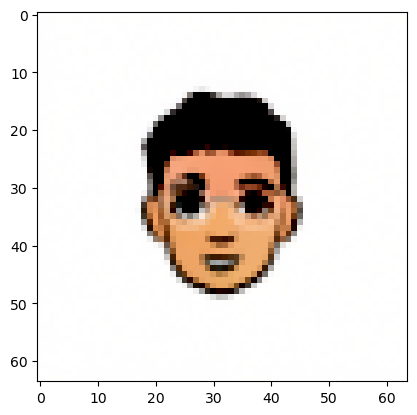

In [14]:
inference("../model_epoch_50.pth")